# Julia is fast

Very often, benchmarks are used to compare languages.  These benchmarks can lead to long discussions, first as to exactly what is being benchmarked and secondly what explains the differences.  These simple questions can sometimes get more complicated than you at first might imagine.

The purpose of this notebook is for you to see a simple benchmark for yourself.  One can read the notebook and see what happened on the author's Macbook Pro with a 4-core Intel Core I7, or run the notebook yourself.

(This material began life as a wonderful lecture by Steven Johnson at MIT: https://github.com/stevengj/18S096-iap17/blob/master/lecture1/Boxes-and-registers.ipynb.)

# `sum`: An easy enough function to understand

Consider the  **sum** function `sum(a)`, which computes
$$
\mathrm{sum}(a) = \sum_{i=1}^n a_i,
$$
where $n$ is the length of `a`.

In [ ]:
a = rand(10^7) # 1D vector of random numbers, uniform on [0,1)

In [ ]:
sum(a)

In [ ]:
@time sum(a)

@time sum(a)

@time sum(a)


The expected result is 0.5 * 10^7, since the mean of each entry is 0.5

# Benchmarking a few ways in a few languages

Julia has a `BenchmarkTools.jl` package for easy and accurate benchmarking:

In [ ]:
using BenchmarkTools  

#  1. The C language

C is often considered the gold standard: difficult on the human, nice for the machine. Getting within a factor of 2 of C is often satisfying. Nonetheless, even within C, there are many kinds of optimizations possible that a naive C writer may or may not get the advantage of.

The current author does not speak C, so he does not read the cell below, but is happy to know that you can put C code in a Julia session, compile it, and run it. Note that the `"""` wrap a multi-line string.

In [ ]:
C_code = """
#include <stddef.h>
double c_sum(size_t n, double *X) {
    double s = 0.0;
    for (size_t i = 0; i < n; ++i) {
        s += X[i];
    }
    return s;
}
"""

const Clib = tempname()   # make a temporary file


# compile to a shared library by piping C_code to gcc
# (works only if you have gcc installed):

open(`gcc -fPIC -O3 -msse3 -xc -shared -o $(Clib * "." * Libdl.dlext) -`, "w") do f
    print(f, C_code) 
end

# define a Julia function that calls the C function:
c_sum(X::Array{Float64}) = ccall(("c_sum", Clib), Float64, (Csize_t, Ptr{Float64}), length(X), X)

In [ ]:
c_sum(a)

In [ ]:
c_sum(a) ≈ sum(a) # type \approx and then <TAB> to get the ≈ symbolb

In [ ]:
c_sum(a) - sum(a)  

In [11]:
≈  # alias for the `isapprox` function

isapprox (generic function with 3 methods)

In [12]:
?isapprox

search: isapprox



```
isapprox(x, y; rtol::Real=sqrt(eps), atol::Real=0, nans::Bool=false, norm::Function)
```

Inexact equality comparison: `true` if `norm(x-y) <= atol + rtol*max(norm(x), norm(y))`. The default `atol` is zero and the default `rtol` depends on the types of `x` and `y`. The keyword argument `nans` determines whether or not NaN values are considered equal (defaults to false).

For real or complex floating-point values, `rtol` defaults to `sqrt(eps(typeof(real(x-y))))`. This corresponds to requiring equality of about half of the significand digits. For other types, `rtol` defaults to zero.

`x` and `y` may also be arrays of numbers, in which case `norm` defaults to `vecnorm` but may be changed by passing a `norm::Function` keyword argument. (For numbers, `norm` is the same thing as `abs`.) When `x` and `y` are arrays, if `norm(x-y)` is not finite (i.e. `±Inf` or `NaN`), the comparison falls back to checking whether all elements of `x` and `y` are approximately equal component-wise.

The binary operator `≈` is equivalent to `isapprox` with the default arguments, and `x ≉ y` is equivalent to `!isapprox(x,y)`.

```jldoctest
julia> 0.1 ≈ (0.1 - 1e-10)
true

julia> isapprox(10, 11; atol = 2)
true

julia> isapprox([10.0^9, 1.0], [10.0^9, 2.0])
true
```


We can now benchmark the C code directly from Julia:

In [13]:
c_bench = @benchmark c_sum($a)

BenchmarkTools.Trial: 
  memory estimate:  0 bytes
  allocs estimate:  0
  --------------
  minimum time:     10.823 ms (0.00% GC)
  median time:      12.023 ms (0.00% GC)
  mean time:        12.887 ms (0.00% GC)
  maximum time:     20.646 ms (0.00% GC)
  --------------
  samples:          388
  evals/sample:     1

In [14]:
println("C: Fastest time was $(minimum(c_bench.times) / 1e6) msec")

C: Fastest time was 10.822984 msec


In [15]:
d = Dict()  # a "dictionary", i.e. an associative array
d["C"] = minimum(c_bench.times) / 1e6  # in milliseconds
d

Dict{Any,Any} with 1 entry:
  "C" => 10.823

In [16]:
using Plots
gr()

Plots.GRBackend()

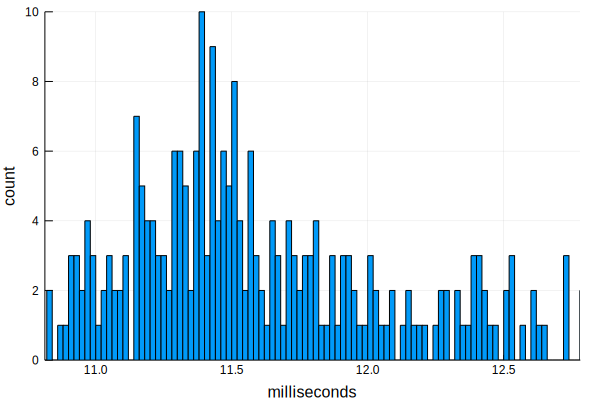

In [18]:
t = c_bench.times / 1e6 # times in milliseconds
m, σ = minimum(t), std(t)

histogram(t, bins=500,
    xlim=(m - 0.01, m + σ),
    xlabel="milliseconds", ylabel="count", label="")

# 2. Python's built in `sum` 

The `PyCall` package provides a Julia interface to Python:

In [19]:
using PyCall

In [20]:
# Call a low-level PyCall function to get a Python list, because
# by default PyCall will convert to a NumPy array instead (we benchmark NumPy below):

apy_list = PyCall.array2py(a, 1, 1)

# get the Python built-in "sum" function:
pysum = pybuiltin("sum")

PyObject <built-in function sum>

In [21]:
pysum(a)

5.000271051110415e6

In [22]:
pysum(a) ≈ sum(a)

true

In [23]:
py_list_bench = @benchmark $pysum($apy_list)

BenchmarkTools.Trial: 
  memory estimate:  512 bytes
  allocs estimate:  17
  --------------
  minimum time:     90.442 ms (0.00% GC)
  median time:      101.516 ms (0.00% GC)
  mean time:        103.648 ms (0.00% GC)
  maximum time:     139.956 ms (0.00% GC)
  --------------
  samples:          49
  evals/sample:     1

In [24]:
d["Python built-in"] = minimum(py_list_bench.times) / 1e6
d

Dict{Any,Any} with 2 entries:
  "C"               => 10.823
  "Python built-in" => 90.4418

# 3. Python: `numpy` 

## Takes advantage of hardware "SIMD", but only works when it works.

`numpy` is an optimized C library, callable from Python.
It may be installed within Julia as follows:

In [25]:
using Conda

In [26]:
numpy_sum = pyimport("numpy")["sum"]
apy_numpy = PyObject(a) # converts to a numpy array by default

py_numpy_bench = @benchmark $numpy_sum($apy_numpy)

BenchmarkTools.Trial: 
  memory estimate:  720 bytes
  allocs estimate:  22
  --------------
  minimum time:     5.705 ms (0.00% GC)
  median time:      7.160 ms (0.00% GC)
  mean time:        8.185 ms (0.00% GC)
  maximum time:     21.422 ms (0.00% GC)
  --------------
  samples:          610
  evals/sample:     1

In [27]:
numpy_sum(apy_list) # python thing

5.000271051110541e6

In [28]:
numpy_sum(apy_list) ≈ sum(a)

true

In [29]:
d["Python numpy"] = minimum(py_numpy_bench.times) / 1e6
d

Dict{Any,Any} with 3 entries:
  "C"               => 10.823
  "Python numpy"    => 5.70475
  "Python built-in" => 90.4418

# 4. Python, hand-written 

In [30]:
py"""
def py_sum(a):
    s = 0.0
    for x in a:
        s = s + x
    return s
"""

sum_py = py"py_sum"

PyObject <function py_sum at 0x133d9aed8>

In [31]:
py_hand = @benchmark $sum_py($apy_list)

BenchmarkTools.Trial: 
  memory estimate:  512 bytes
  allocs estimate:  17
  --------------
  minimum time:     1.892 s (0.00% GC)
  median time:      1.893 s (0.00% GC)
  mean time:        1.911 s (0.00% GC)
  maximum time:     1.949 s (0.00% GC)
  --------------
  samples:          3
  evals/sample:     1

In [32]:
@which sum([1.5])

sum(a) in Base at reduce.jl:359

In [33]:
sum_py(apy_list)

5.000271051110415e6

In [34]:
sum_py(apy_list) ≈ sum(a)

true

In [35]:
d["Python hand-written"] = minimum(py_hand.times) / 1e6
d

Dict{Any,Any} with 4 entries:
  "C"                   => 10.823
  "Python numpy"        => 5.70475
  "Python hand-written" => 1891.88
  "Python built-in"     => 90.4418

# 5. Julia (built-in) 

## Written directly in Julia, not in C!

In [36]:
@which sum(a)

sum(a) in Base at reduce.jl:359

In [37]:
j_bench = @benchmark sum($a)

BenchmarkTools.Trial: 
  memory estimate:  0 bytes
  allocs estimate:  0
  --------------
  minimum time:     5.527 ms (0.00% GC)
  median time:      7.600 ms (0.00% GC)
  mean time:        7.978 ms (0.00% GC)
  maximum time:     74.378 ms (0.00% GC)
  --------------
  samples:          625
  evals/sample:     1

In [38]:
d["Julia built-in"] = minimum(j_bench.times) / 1e6
d

Dict{Any,Any} with 5 entries:
  "C"                   => 10.823
  "Python numpy"        => 5.70475
  "Python hand-written" => 1891.88
  "Python built-in"     => 90.4418
  "Julia built-in"      => 5.52724

# 6. Julia (hand-written) 

In [39]:
function mysum(A)   
    s = 0.0 # s = zero(eltype(A))
    for a in A
        s += a
    end
    s
end

mysum (generic function with 1 method)

In [40]:
j_bench_hand = @benchmark mysum($a)

BenchmarkTools.Trial: 
  memory estimate:  0 bytes
  allocs estimate:  0
  --------------
  minimum time:     10.959 ms (0.00% GC)
  median time:      13.415 ms (0.00% GC)
  mean time:        14.068 ms (0.00% GC)
  maximum time:     23.830 ms (0.00% GC)
  --------------
  samples:          355
  evals/sample:     1

In [41]:
d["Julia hand-written"] = minimum(j_bench_hand.times) / 1e6
d

Dict{Any,Any} with 6 entries:
  "C"                   => 10.823
  "Python numpy"        => 5.70475
  "Julia hand-written"  => 10.9594
  "Python hand-written" => 1891.88
  "Python built-in"     => 90.4418
  "Julia built-in"      => 5.52724

# 7. Julia (hand-written w. simd) 

In [51]:
function mysum_simd(A)   
    s = 0.0 # s = zero(eltype(A))
    @simd for a in A
        s += a
    end
    s
end

mysum_simd (generic function with 1 method)

In [49]:
j_bench_hand_simd = @benchmark mysum_simd($a)

BenchmarkTools.Trial: 
  memory estimate:  191.63 MiB
  allocs estimate:  13156386
  --------------
  minimum time:     832.061 ms (0.00% GC)
  median time:      918.739 ms (0.00% GC)
  mean time:        939.917 ms (0.00% GC)
  maximum time:     1.110 s (0.00% GC)
  --------------
  samples:          6
  evals/sample:     1

In [50]:
mysum_simd(a)

1.6670702768809334e6

In [44]:
d["Julia hand-written simd"] = minimum(j_bench_hand_simd.times) / 1e6
d

Dict{Any,Any} with 7 entries:
  "Julia hand-written simd" => 5.67683
  "C"                       => 10.823
  "Python numpy"            => 5.70475
  "Julia hand-written"      => 10.9594
  "Python hand-written"     => 1891.88
  "Python built-in"         => 90.4418
  "Julia built-in"          => 5.52724

# Summary

In [45]:
for (key, value) in sort(collect(d), by=last)
    println(rpad(key, 25, "."), lpad(round(value, 1), 6, "."))
end

Julia built-in..............5.5
Julia hand-written simd.....5.7
Python numpy................5.7
C..........................10.8
Julia hand-written.........11.0
Python built-in............90.4
Python hand-written......1891.9
